# PCA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import plotly.graph_objs as go


In [2]:
wine_data=pd.read_csv("wine.csv")
wine_data.head()

Type  Alcohol  Malic   Ash  Alcalinity  Magnesium  Phenols  Flavanoids  \
0     1    14.23   1.71  2.43        15.6        127     2.80        3.06   
1     1    13.20   1.78  2.14        11.2        100     2.65        2.76   
2     1    13.16   2.36  2.67        18.6        101     2.80        3.24   
3     1    14.37   1.95  2.50        16.8        113     3.85        3.49   
4     1    13.24   2.59  2.87        21.0        118     2.80        2.69   

   Nonflavanoids  Proanthocyanins  Color   Hue  Dilution  Proline  
0           0.28             2.29   5.64  1.04      3.92     1065  
1           0.26             1.28   4.38  1.05      3.40     1050  
2           0.30             2.81   5.68  1.03      3.17     1185  
3           0.24             2.18   7.80  0.86      3.45     1480  
4           0.39             1.82   4.32  1.04      2.93      735

# EDA

In [3]:
wine_data["Type"].value_counts()

2    71
1    59
3    48
Name: Type, dtype: int64

In [4]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             178 non-null    int64  
 1   Alcohol          178 non-null    float64
 2   Malic            178 non-null    float64
 3   Ash              178 non-null    float64
 4   Alcalinity       178 non-null    float64
 5   Magnesium        178 non-null    int64  
 6   Phenols          178 non-null    float64
 7   Flavanoids       178 non-null    float64
 8   Nonflavanoids    178 non-null    float64
 9   Proanthocyanins  178 non-null    float64
 10  Color            178 non-null    float64
 11  Hue              178 non-null    float64
 12  Dilution         178 non-null    float64
 13  Proline          178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [5]:
wine_data.iloc[:,1:].describe()

Alcohol       Malic         Ash  Alcalinity   Magnesium     Phenols  \
count  178.000000  178.000000  178.000000  178.000000  178.000000  178.000000   
mean    13.000618    2.336348    2.366517   19.494944   99.741573    2.295112   
std      0.811827    1.117146    0.274344    3.339564   14.282484    0.625851   
min     11.030000    0.740000    1.360000   10.600000   70.000000    0.980000   
25%     12.362500    1.602500    2.210000   17.200000   88.000000    1.742500   
50%     13.050000    1.865000    2.360000   19.500000   98.000000    2.355000   
75%     13.677500    3.082500    2.557500   21.500000  107.000000    2.800000   
max     14.830000    5.800000    3.230000   30.000000  162.000000    3.880000   

       Flavanoids  Nonflavanoids  Proanthocyanins       Color         Hue  \
count  178.000000     178.000000       178.000000  178.000000  178.000000   
mean     2.029270       0.361854         1.590899    5.058090    0.957449   
std      0.998859       0.124453         0.572359    2.318286    0.228572   
min      0.340000       0.130000         0.410000    1.280000    0.480000   
25%      1.205000       0.270000         1.250000    3.220000    0.782500   
50%      2.135000       0.340000         1.555000    4.690000    0.965000   
75%      2.875000       0.437500         1.950000    6.200000    1.120000   
max      5.080000       0.660000         3.580000   13.000000    1.710000   

         Dilution      Proline  
count  178.000000   178.000000  
mean     2.611685   746.893258  
std      0.709990   314.907474  
min      1.270000   278.000000  
25%      1.937500   500.500000  
50%      2.780000   673.500000  
75%      3.170000   985.000000  
max      4.000000  1680.000000

<AxesSubplot:xlabel='Alcohol', ylabel='Phenols'>

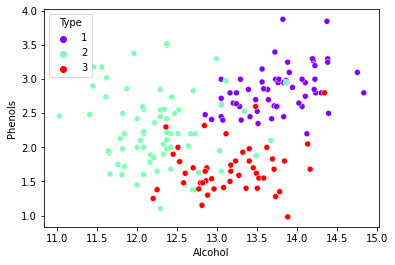

In [6]:
sns.scatterplot(x="Alcohol",y="Phenols",data=wine_data,hue="Type",palette="rainbow" )

In [7]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'Alcohol -->'),yaxis = dict(title  = 'Phenols--->'),zaxis = dict(title  = 'Flavanoids-->'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = wine_data["Type"]
trace = go.Scatter3d(x=wine_data["Alcohol"], y=wine_data["Phenols"], z=wine_data["Flavanoids"], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

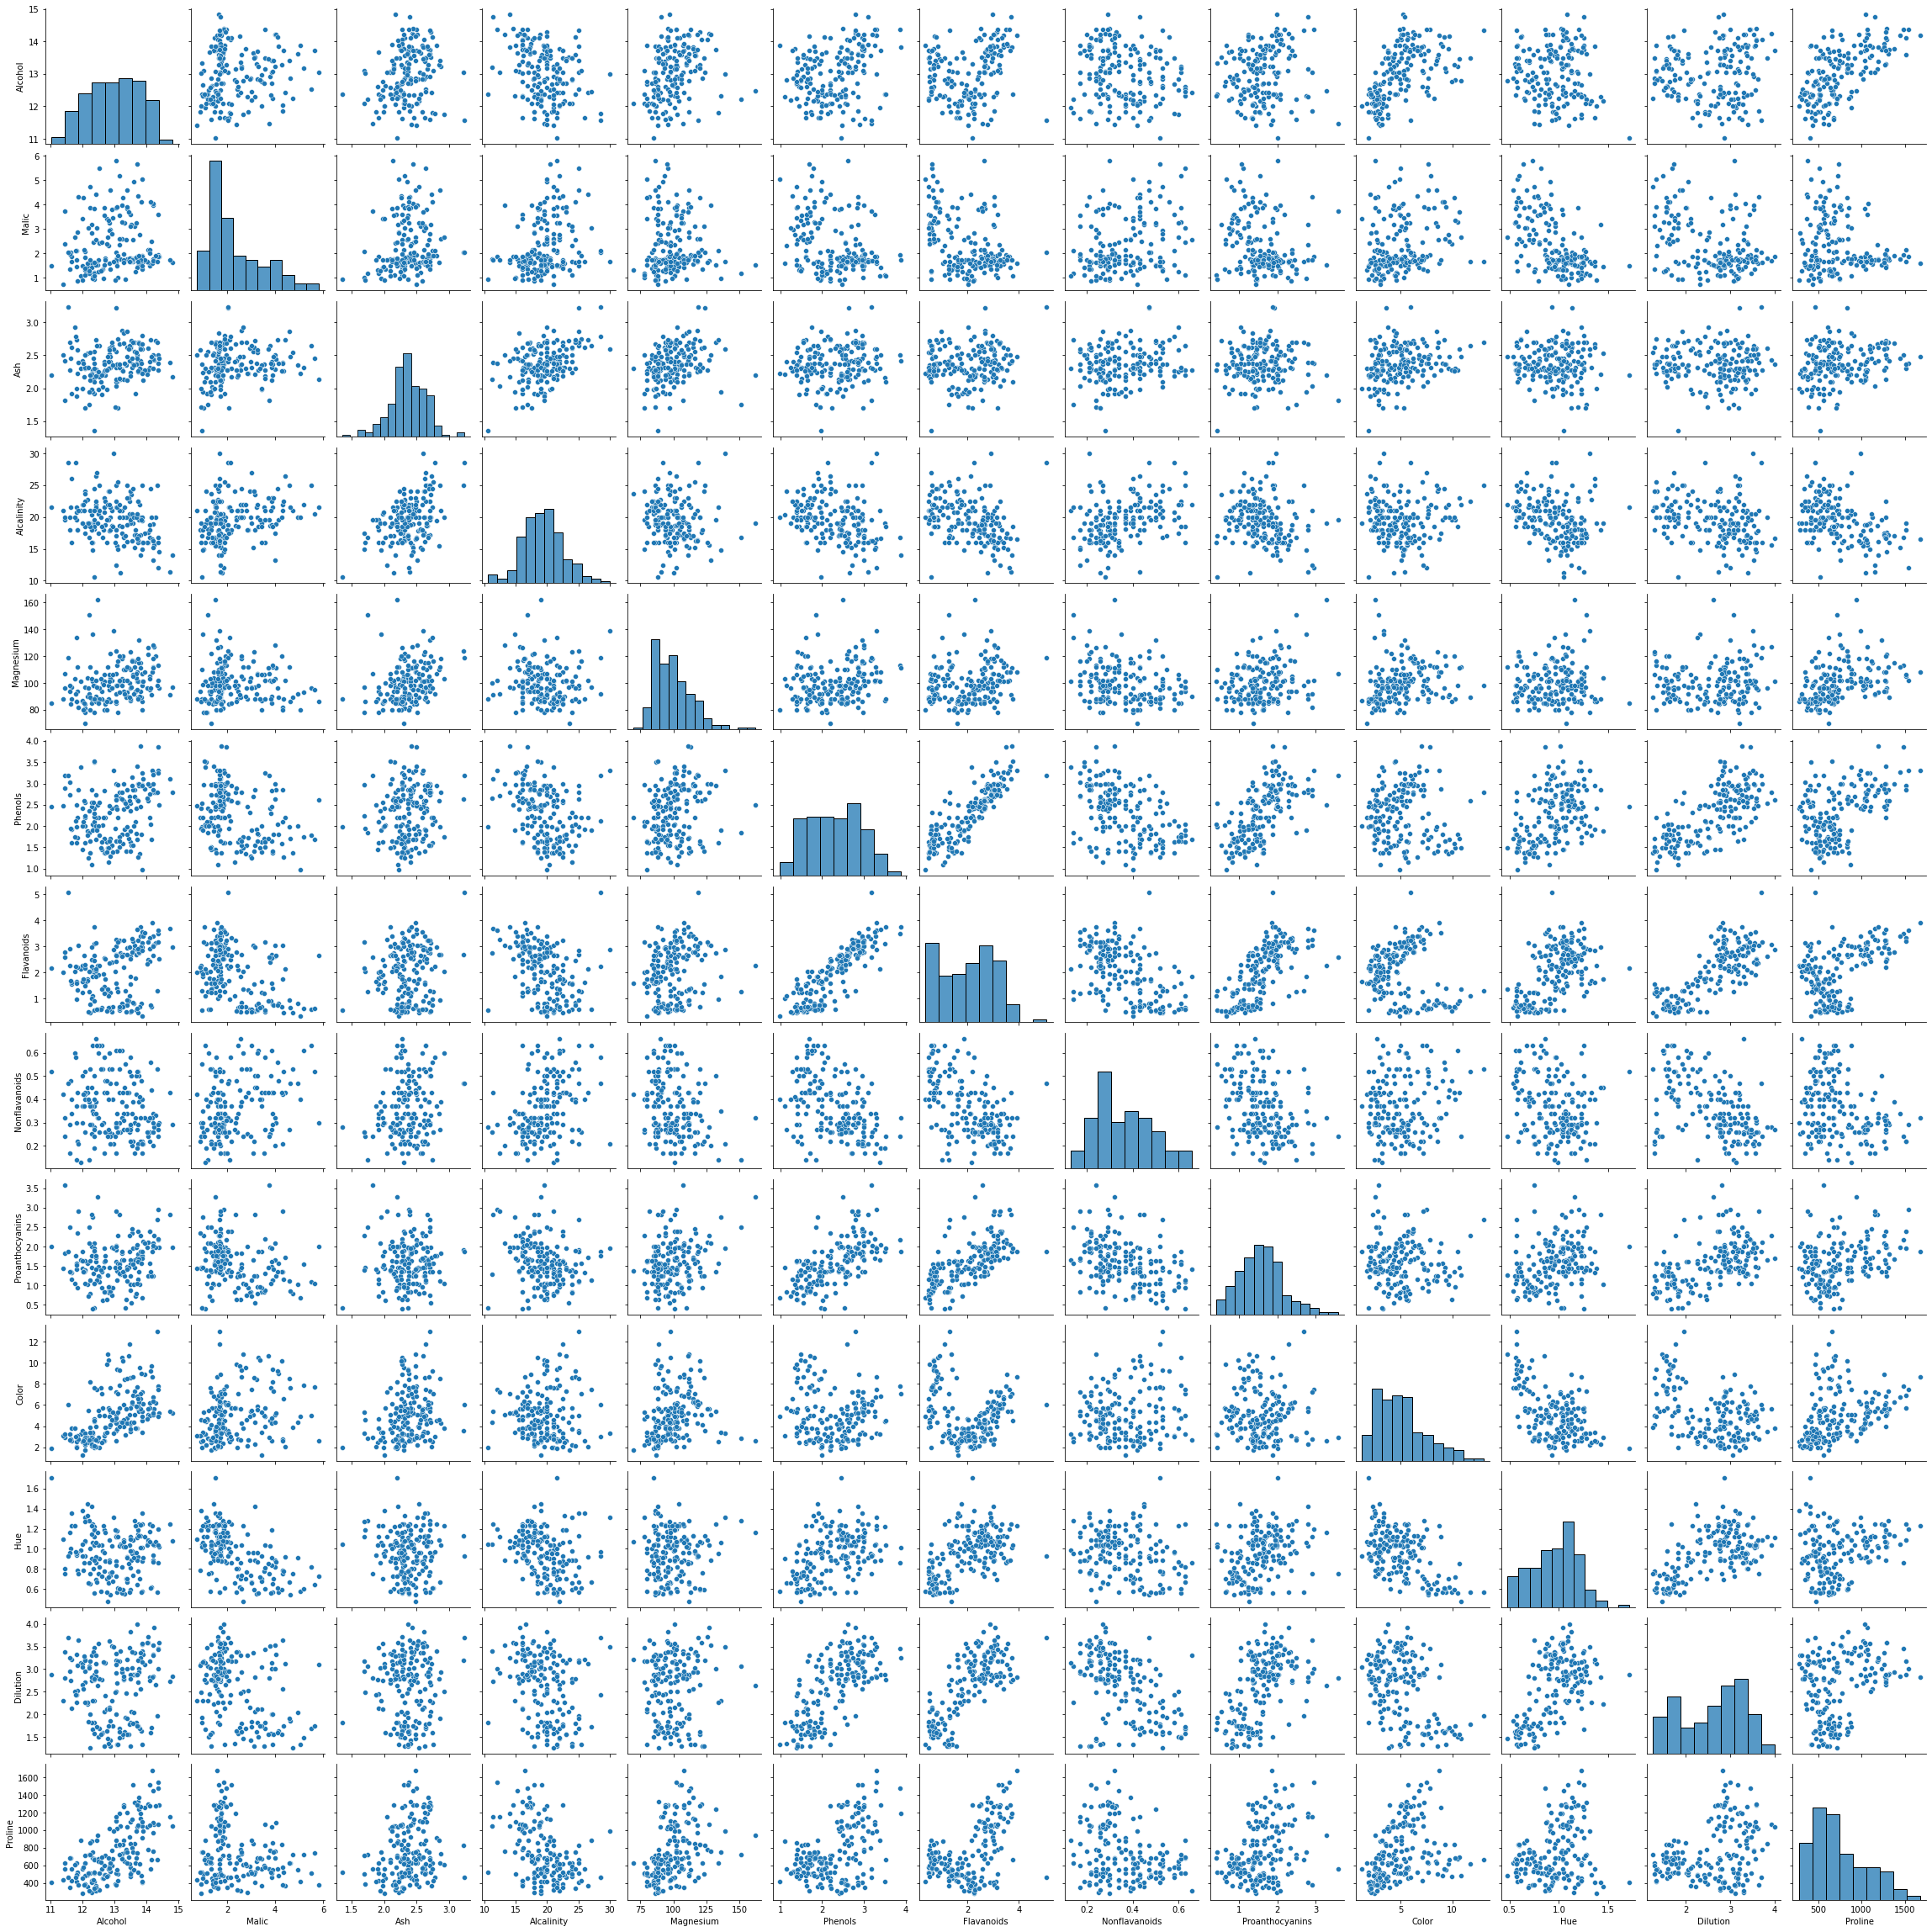

In [8]:
sns.pairplot(wine_data.iloc[:,1:])

## Scaling

In [9]:
wine_scale=scale(wine_data.iloc[:,1:])

# <span style="color:Red">Clustering without PCA</span>

# `Hierarchical`

Text(0, 0.5, 'Euclidean Distance')

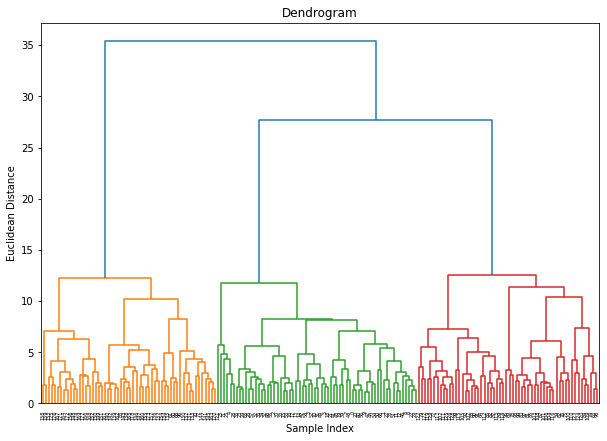

In [10]:
plt.figure(figsize=(10,7))
sch.dendrogram(sch.linkage(wine_scale,method="ward"))
plt.title("Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Euclidean Distance")

## Model Training

In [11]:
s_score=[]
ch_score=[]
clusters=[2,3,4,5,6]
wcd=[]  ## for elbow curve
for n in clusters:
    model_hier=AgglomerativeClustering(n_clusters=n,affinity="euclidean",linkage="ward")
    model_hier.fit(wine_scale)
    s_score.append(silhouette_score(wine_scale,model_hier.labels_))
    ch_score.append(calinski_harabasz_score(wine_scale,model_hier.labels_))
hier_df=pd.DataFrame({"clusters":clusters,"silhouette":s_score,"Calinski_harabasz":ch_score})

In [12]:
hier_df

clusters  silhouette  Calinski_harabasz
0         2    0.267013          65.360838
1         3    0.277444          67.647468
2         4    0.225837          51.464146
3         5    0.186742          43.679272
4         6    0.179666          39.128964

#### 3 clustered case looks best in these cases

<AxesSubplot:xlabel='Alcohol', ylabel='Phenols'>

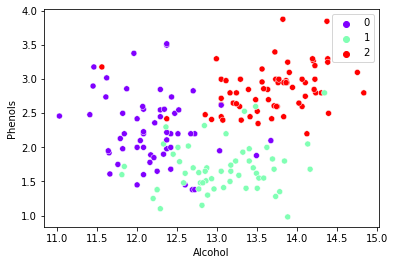

In [13]:
model_hier=AgglomerativeClustering(n_clusters=3,affinity="euclidean",linkage="ward")
model_hier.fit(wine_scale)
sns.scatterplot(x="Alcohol",y="Phenols",data=wine_data,hue=model_hier.labels_,palette="rainbow" )

# `KMeans`

## Model Training

In [14]:
s_score=[]
ch_score=[]
clusters=[2,3,4,5,6]
wcd=[]   ## for elbow curve
for n in clusters:
    model_kmeans=KMeans(n_clusters=n,random_state=10)
    model_kmeans.fit(wine_scale)
    s_score.append(silhouette_score(wine_scale,model_kmeans.labels_))
    ch_score.append(calinski_harabasz_score(wine_scale,model_kmeans.labels_))
    wcd.append(model_kmeans.inertia_)
kmeans_df=pd.DataFrame({"clusters":clusters,"silhouette":s_score,"Calinski_harabasz":ch_score})

#### In both hierarchical and kmeans 3 clusters cases if showing good score and kmeans is showing slight better result then hierarcy

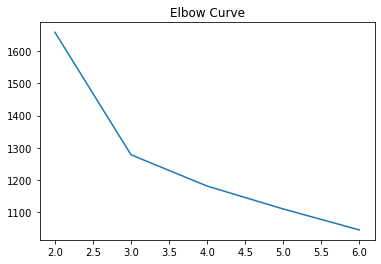

In [15]:
plt.title("Elbow Curve")
plt.plot(clusters,wcd)

<AxesSubplot:xlabel='Alcohol', ylabel='Phenols'>

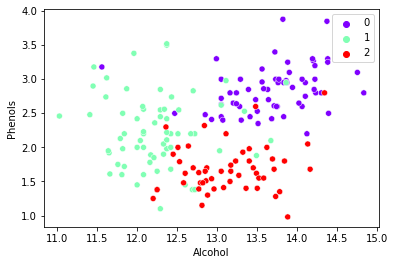

In [16]:
model_kmeans=KMeans(n_clusters=3,random_state=10)
model_kmeans.fit(wine_scale)
sns.scatterplot(x="Alcohol",y="Phenols",data=wine_data,hue=model_kmeans.labels_,palette="rainbow" )

# <span style="color:Red">Clustering with PCA</span>

### Applying PCA

In [17]:
pca=PCA()
pca_values=pca.fit_transform(wine_scale)

In [18]:
pca_values.shape

(178, 13)

In [19]:
pca.explained_variance_

array([4.73243698, 2.51108093, 1.45424187, 0.92416587, 0.85804868,
       0.64528221, 0.55414147, 0.35046627, 0.29051203, 0.25232001,
       0.22706428, 0.16972374, 0.10396199])

In [20]:
var=pca.explained_variance_ratio_

In [21]:
var1=np.cumsum(np.round(var,decimals=4)*100)
var1

array([ 36.2 ,  55.41,  66.53,  73.6 ,  80.16,  85.1 ,  89.34,  92.02,
        94.24,  96.17,  97.91,  99.21, 100.01])

In [22]:
pca_values

array([[ 3.31675081e+00, -1.44346263e+00, -1.65739045e-01, ...,
        -4.51563395e-01,  5.40810414e-01, -6.62386309e-02],
       [ 2.20946492e+00,  3.33392887e-01, -2.02645737e+00, ...,
        -1.42657306e-01,  3.88237741e-01,  3.63650247e-03],
       [ 2.51674015e+00, -1.03115130e+00,  9.82818670e-01, ...,
        -2.86672847e-01,  5.83573183e-04,  2.17165104e-02],
       ...,
       [-2.67783946e+00, -2.76089913e+00, -9.40941877e-01, ...,
         5.12492025e-01,  6.98766451e-01,  7.20776948e-02],
       [-2.38701709e+00, -2.29734668e+00, -5.50696197e-01, ...,
         2.99821968e-01,  3.39820654e-01, -2.18657605e-02],
       [-3.20875816e+00, -2.76891957e+00,  1.01391366e+00, ...,
        -2.29964331e-01, -1.88787963e-01, -3.23964720e-01]])

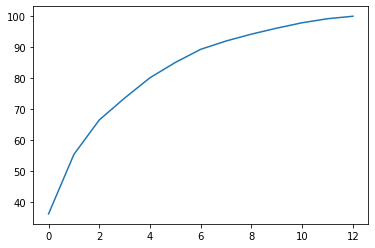

In [23]:
plt.plot(var1)

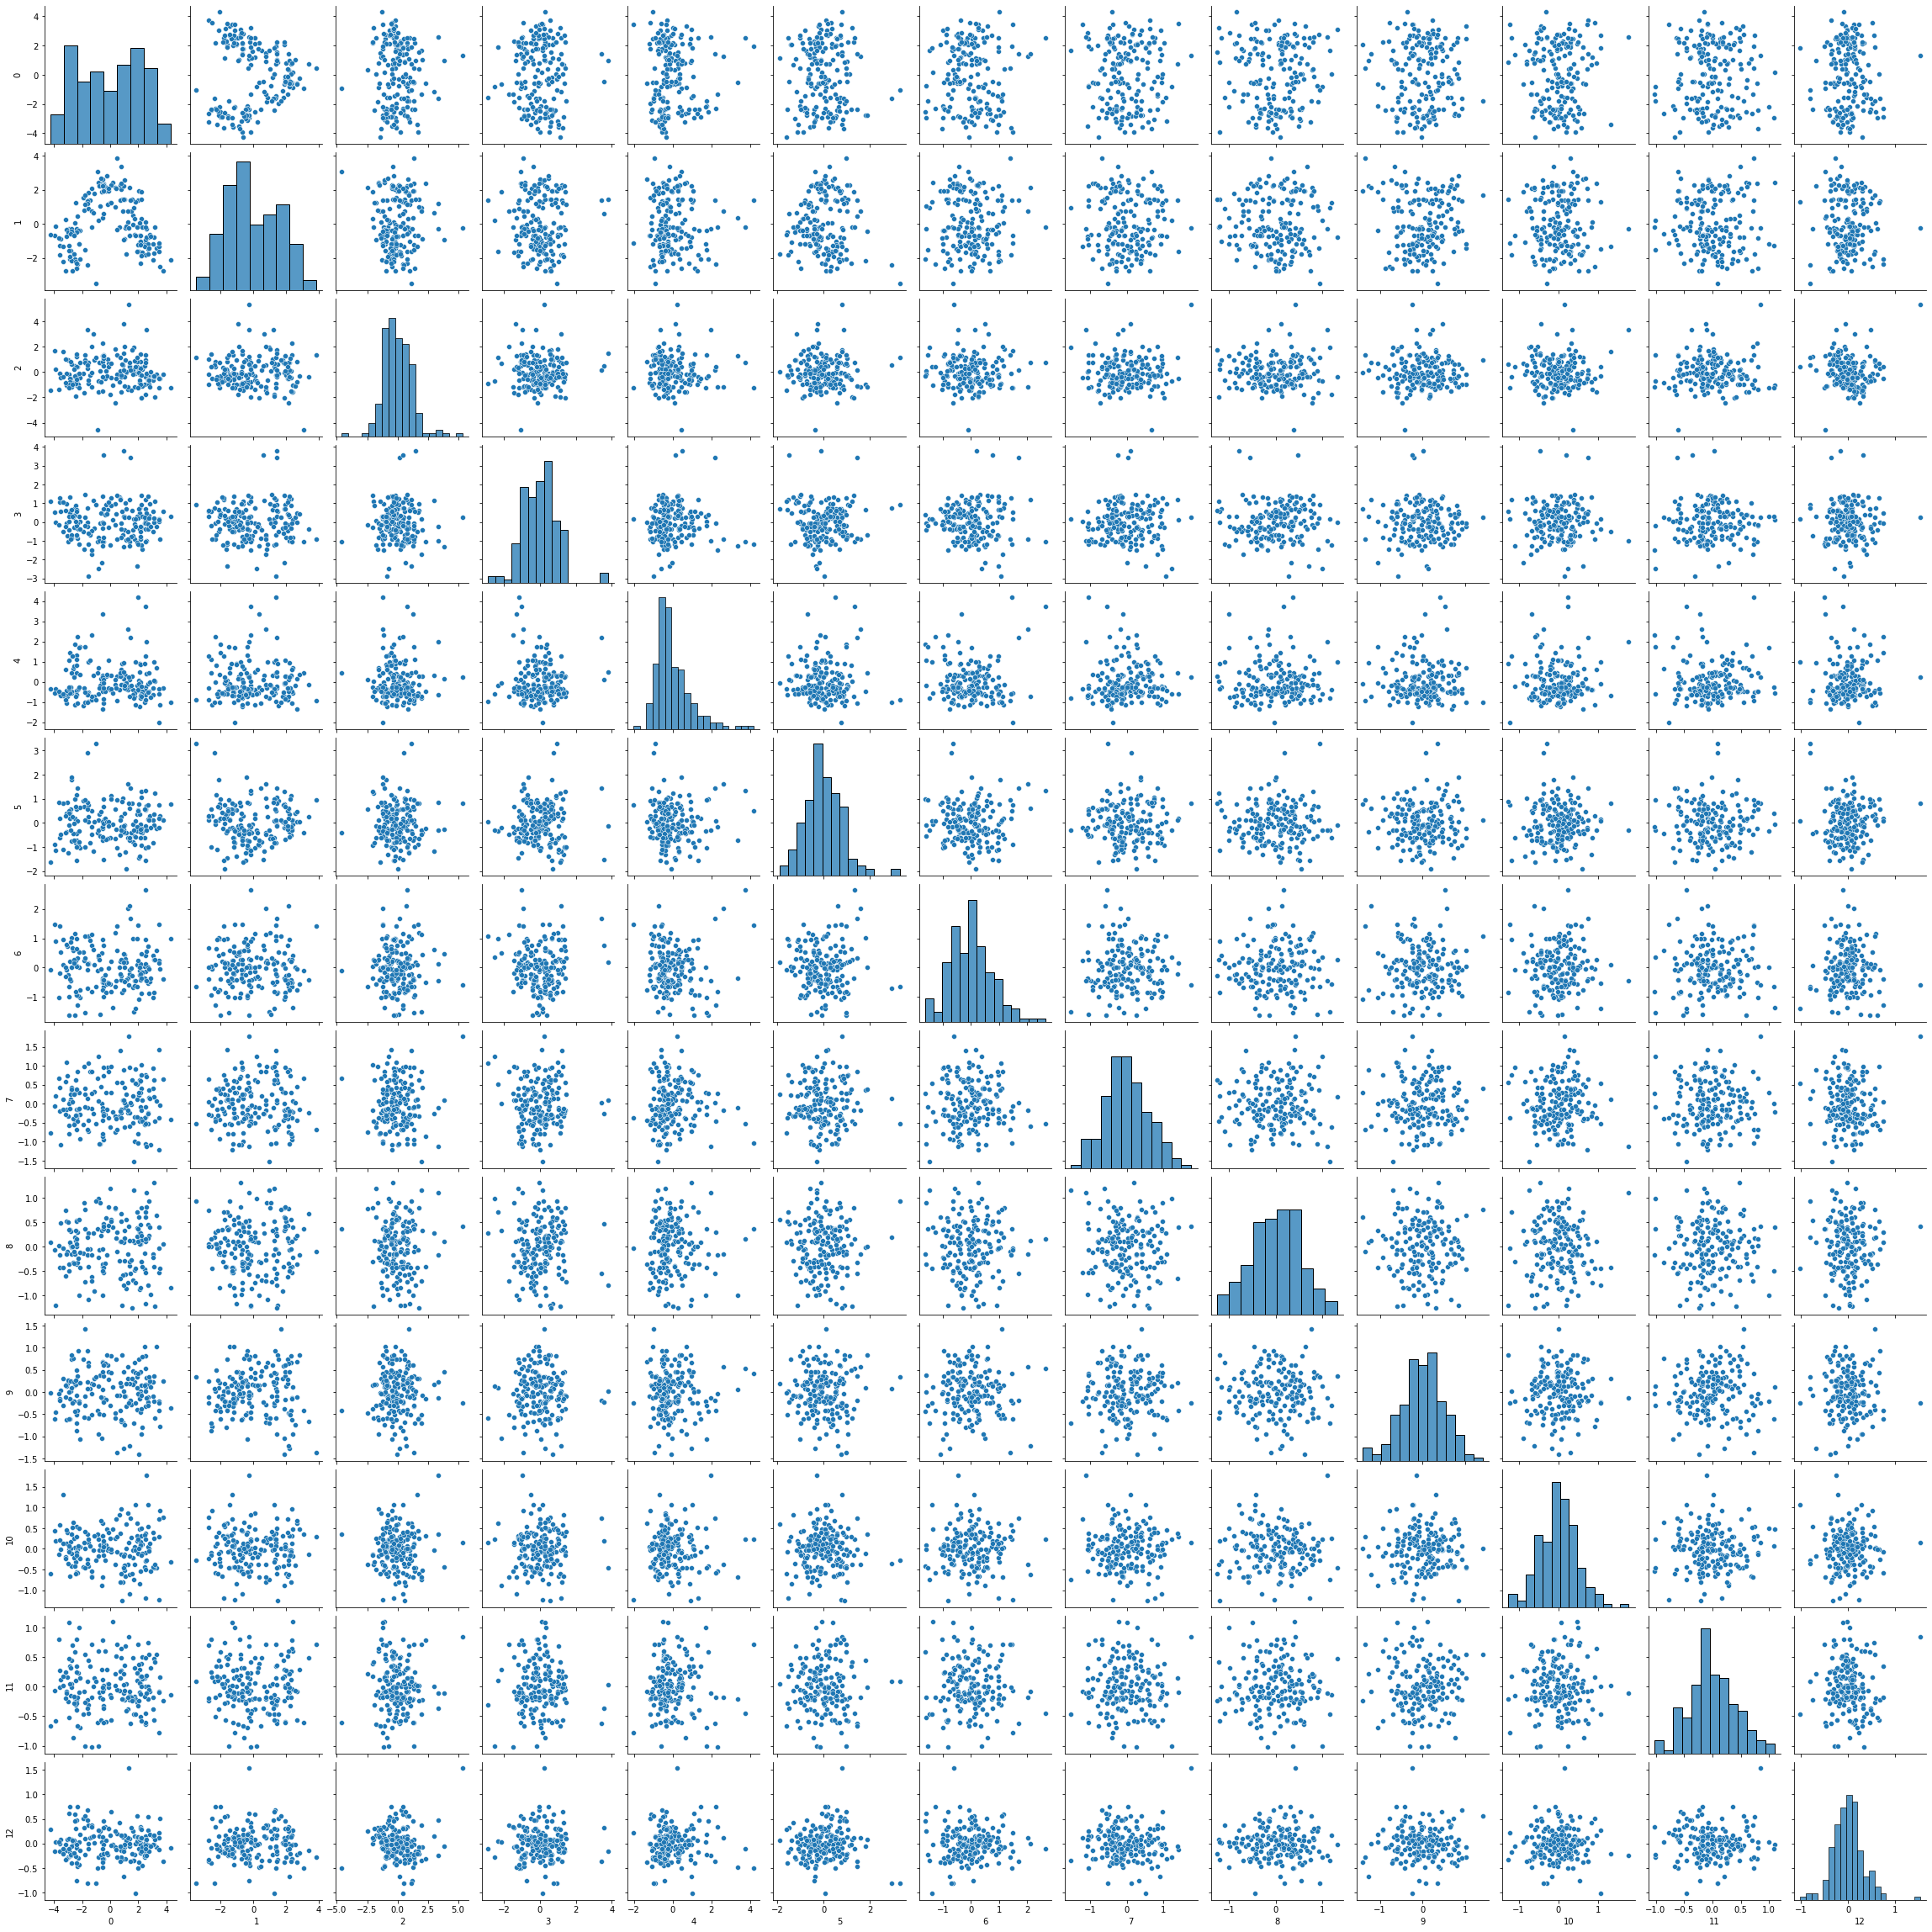

In [24]:
sns.pairplot(pd.DataFrame(pca_values))

### Performing Modeling with first 3 components

In [25]:
pca_3_comp=pca_values[:,0:3]

# `Hierarchical Clustering`

## Model Training

Text(0, 0.5, 'Euclidean Distance')

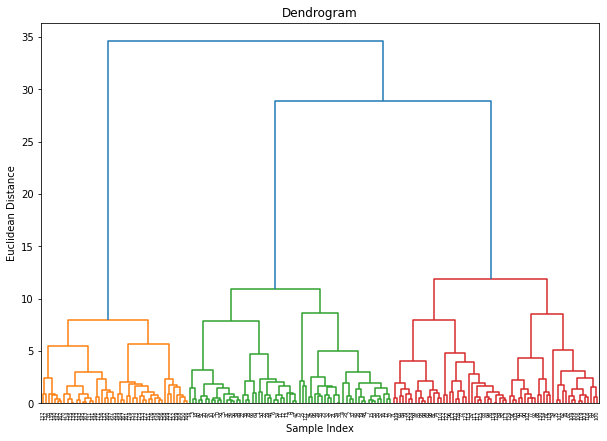

In [26]:
plt.figure(figsize=(10,7))
sch.dendrogram(sch.linkage(pca_3_comp,method="ward"))
plt.title("Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Euclidean Distance")

In [27]:
s_score=[]
ch_score=[]
clusters=[2,3,4,5,6]
wcd=[]  ## for elbow curve
for n in clusters:
    model_hier=AgglomerativeClustering(n_clusters=n,affinity="euclidean",linkage="ward")
    model_hier.fit(pca_3_comp)
    s_score.append(silhouette_score(pca_3_comp,model_hier.labels_))
    ch_score.append(calinski_harabasz_score(pca_3_comp,model_hier.labels_))
hier_pca_df=pd.DataFrame({"clusters":clusters,"silhouette":s_score,"Calinski_harabasz":ch_score})

In [28]:
hier_pca_df

clusters  silhouette  Calinski_harabasz
0         2    0.395090         112.030153
1         3    0.445949         170.247945
2         4    0.381957         139.314013
3         5    0.319488         126.192476
4         6    0.319933         114.630878

<AxesSubplot:xlabel='Alcohol', ylabel='Phenols'>

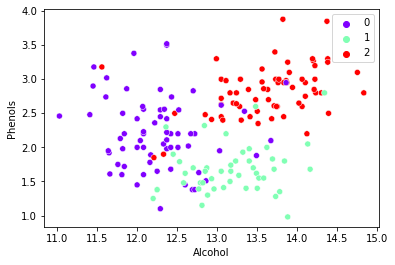

In [29]:
model_hier=AgglomerativeClustering(n_clusters=3,affinity="euclidean",linkage="ward")
model_hier.fit(pca_3_comp)
sns.scatterplot(x="Alcohol",y="Phenols",data=wine_data,hue=model_hier.labels_,palette="rainbow" )

# `KMeans`

# Model Training

In [30]:
s_score=[]
ch_score=[]
clusters=[2,3,4,5,6]
wcd=[]   ## for elbow curve
for n in clusters:
    model_kmeans=KMeans(n_clusters=n,random_state=10)
    model_kmeans.fit(pca_3_comp)
    s_score.append(silhouette_score(pca_3_comp,model_kmeans.labels_))
    ch_score.append(calinski_harabasz_score(pca_3_comp,model_kmeans.labels_))
    wcd.append(model_kmeans.inertia_)
kmeans_pca_df=pd.DataFrame({"clusters":clusters,"silhouette":s_score,"Calinski_harabasz":ch_score})

In [31]:
kmeans_pca_df

clusters  silhouette  Calinski_harabasz
0         2    0.389388         129.759981
1         3    0.453235         175.086129
2         4    0.411812         149.884633
3         5    0.388933         134.252996
4         6    0.308875         127.624730

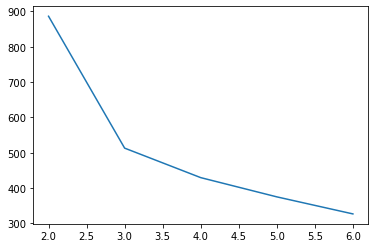

In [32]:
plt.plot(clusters,wcd)

<AxesSubplot:xlabel='Alcohol', ylabel='Phenols'>

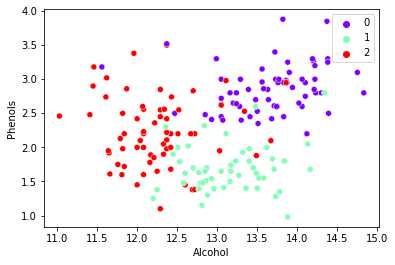

In [33]:
model_kmeans=KMeans(n_clusters=3,random_state=10)
model_kmeans.fit(pca_3_comp)
sns.scatterplot(x="Alcohol",y="Phenols",data=wine_data,hue=model_kmeans.labels_,palette="rainbow" )

In [34]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'Alcohol -->'),yaxis = dict(title  = 'Phenols--->'),zaxis = dict(title  = 'Flavanoids-->'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = model_kmeans.labels_
trace = go.Scatter3d(x=wine_data["Alcohol"], y=wine_data["Phenols"], z=wine_data["Flavanoids"], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

## Hence, with 3 components of PCA it is able to explain clusters the same way as original data